In [1]:
import torch as th
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [3]:
class SimpleFCNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(SimpleFCNN, self).__init__()
        self.relu = nn.ReLU()
        # initialize the first layer
        self.first_layer = nn.Linear(input_size, hidden_size)
        self.num_layers = num_layers
        # initialize the layers
        for i in range(num_layers - 2):
            setattr(self, f"fc{i}", nn.Linear(hidden_size, hidden_size))

        # initialize last layer extra
        self.last_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # apply first layer
        x = self.relu(self.first_layer(x))
        # iterate over all layers but the last one
        for i in range(self.num_layers - 2):
            x = self.relu(getattr(self, f"fc{i}")(x))
        # apply last layer without relu
        x = self.last_layer(x)
        return x


In [4]:
class CouplingLayer(nn.Module):
    def __init__(self, num_features, hidden_size, num_layers):
        super(CouplingLayer, self).__init__()
        # Initialize the fully connected network
        upper_split_size = math.ceil(num_features / 2)
        lower_split_size = num_features - upper_split_size
        # self.t = SimpleFCNN(
        #     upper_split_size, hidden_size, 2*lower_split_size, num_layers
        # )
        self.s = SimpleFCNN(
            upper_split_size, hidden_size, 2*lower_split_size, num_layers
        )

    def forward(
        self,
        x,
    ):
        x_1, x_2 = th.tensor_split(x, 2, dim=1)

        s, t = th.tensor_split(self.s(x_1), 2, dim=1)
        # Forward pass through the coupling layer
        x_2 = th.abs(s) * x_2 + t
        log_det_J = th.sum(th.log(th.abs(s)), dim=1)
        return th.cat((x_1, x_2), dim=1), log_det_J

    def backward(self, x):
        x_1, x_2 = th.tensor_split(x, 2, dim=1)
        s, t = th.tensor_split(self.s(x_1), 2, dim=1)
        # Forward pass through the coupling layer
        x_2 = (x_2 - t) / th.abs(s)
        return th.cat((x_1, x_2), dim=1)

In [5]:
class Flow(nn.Module):
    def __init__(self, num_blocks, num_features, hidden_size, num_layers):
        super(Flow, self).__init__()

        self.num_blocks = num_blocks


        for i in range(num_blocks):
            setattr(
                self,
                f"cl_{i}",
                CouplingLayer(
                    num_features, hidden_size, num_layers
                ),
            )

    def forward(self, x):
        log_det_J = 0
        for i in range(self.num_blocks):
            x, _log_det_J = getattr(self, f"cl_{i}").forward(x)
            x = x[:,[1, 0]]
            log_det_J += _log_det_J
            
        return x, log_det_J
    
    def forward_n_layers(self, x, n):
        for i in range(n):
            x, _log_det_J = getattr(self, f"cl_{i}").forward(x)
            x = x[:,[1, 0]]
            
        return x

    def backward(self, x):
        for i in range(self.num_blocks - 1, -1, -1):
            x = x[:, [1, 0]]
            x = getattr(self, f"cl_{i}").backward(x)
        return x
    
    def backward_n_layers(self, x, n):
        for i in range(self.num_blocks - 1, self.num_blocks - 1 - n, -1):
            x = x[:, [1, 0]]
            x = getattr(self, f"cl_{i}").backward(x)
        return x


In [6]:
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
    
    def Isotropic_Gaussian(self, x):
        xx = th.sum(x ** 2, axis=1)    
        return -0.5 * (xx - 2*th.log(th.tensor(2 * th.pi)))

    def forward(self, x, log_det_J, model, lambda_1 = 1e-3):
        mse_penalty = th.nn.MSELoss(size_average=False)
        reg_loss = 0
        for param in model.parameters():
            reg_loss += mse_penalty(param, th.zeros_like(param)) #
        return -th.sum(self.Isotropic_Gaussian(x) + log_det_J) + lambda_1 * reg_loss,  -th.sum(self.Isotropic_Gaussian(x) + log_det_J)

In [7]:
dist = th.distributions.gamma.Gamma(th.tensor([2.0, 1.0]), th.tensor([.5, .5]))
x = dist.sample((1000, 1)).squeeze(1)


x = x.to(device)

In [8]:
num_features = 2  # Number of features in the input
hidden_size = 4 # Number of hidden units in the FCNN
num_layers =  4 # Number of layers in the FCNN
num_blocks = 3  # Number of coupling layers in the flow

# Initialize the flow
flow = Flow(num_blocks, num_features, hidden_size, num_layers)

# Initialize the loss
lossfunc = Loss()
flow.to(device)
loss_arr = []

In [9]:
optimizer = th.optim.Adam(
    [
        {"params": flow.parameters(), "lr": 1e-4},
    ]
)
dataloader = th.utils.data.DataLoader(x, batch_size=5000, shuffle=True)
sheduler = th.optim.lr_scheduler.StepLR(optimizer, step_size=100000, gamma=0.1)
for i in range(25000):
    epochloss = 0
    epochcounter = 0
    epochcleanedloss = 0
    for x_batch in dataloader:
        optimizer.zero_grad()
        loss = 0.0
        y_pred, log_det_J = flow.forward(x_batch.float())
        loss, cleaned_loss = lossfunc.forward(y_pred.float(), log_det_J, flow)
        epochloss += loss
        epochcleanedloss += cleaned_loss
        epochcounter += 1
        loss_arr.append(cleaned_loss.cpu().item())
        loss.backward()

        optimizer.step()
        # sheduler.step()
    if (i%1000 == 0):
        print("Epoch: " + str(i) + " Loss: " + str(epochloss.item()/epochcounter) + " Cleaned Loss: " + str(epochcleanedloss.item()/epochcounter))



/Users/laurin/Library/Python/3.12/lib/python/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 0 Loss: 4891.49951171875 Cleaned Loss: 4891.47998046875
Epoch: 1000 Loss: 1658.3658447265625 Cleaned Loss: 1658.34716796875
Epoch: 2000 Loss: 955.5465087890625 Cleaned Loss: 955.52685546875
Epoch: 3000 Loss: 907.296875 Cleaned Loss: 907.2770385742188
Epoch: 4000 Loss: 865.7075805664062 Cleaned Loss: 865.6863403320312
Epoch: 5000 Loss: 788.6388549804688 Cleaned Loss: 788.6143798828125
Epoch: 6000 Loss: 610.9280395507812 Cleaned Loss: 610.8997802734375
Epoch: 7000 Loss: 516.8645629882812 Cleaned Loss: 516.83349609375
Epoch: 8000 Loss: 419.4760437011719 Cleaned Loss: 419.4410705566406
Epoch: 9000 Loss: 388.5135192871094 Cleaned Loss: 388.4757385253906
Epoch: 10000 Loss: 378.38671875 Cleaned Loss: 378.3468933105469
Epoch: 11000 Loss: 373.2426452636719 Cleaned Loss: 373.2015075683594
Epoch: 12000 Loss: 366.1156005859375 Cleaned Loss: 366.07318115234375
Epoch: 13000 Loss: 361.13446044921875 Cleaned Loss: 361.0906982421875
Epoch: 14000 Loss: 357.88153076171875 Cleaned Loss: 357.8365478

In [10]:
loss_arr[-1]

337.5432434082031

Text(0, 0.5, 'Negative Log Likelihood')

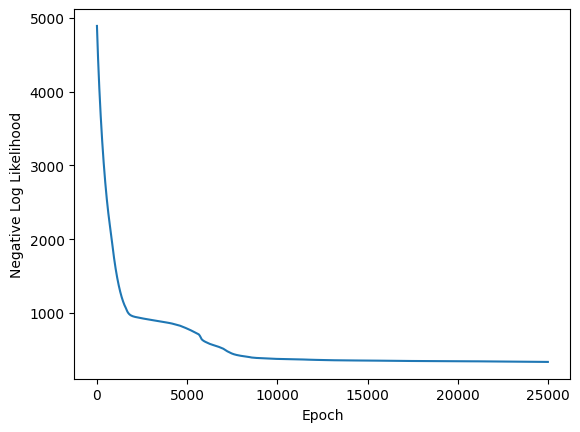

In [11]:
plt.plot(loss_arr)
plt.xlabel("Epoch")
plt.ylabel("Negative Log Likelihood")

tensor([[-0.8395,  0.4582],
        [ 0.8479,  0.0688],
        [-1.7070, -1.1674],
        ...,
        [ 1.9476,  0.1075],
        [-1.3214,  0.1702],
        [ 0.4730,  2.0403]], dtype=torch.float64)


[(-1.0, 10.0), (-1.0, 10.0), Text(0.5, 0, 'X'), Text(0, 0.5, 'Y')]

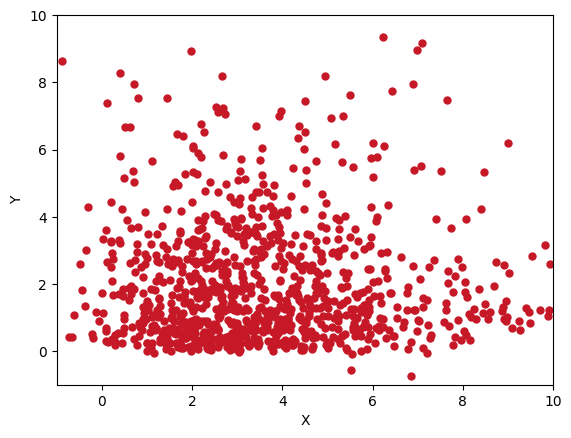

In [12]:
samples = th.tensor(np.random.normal([0, 0], 1, size = (1000, 2))).to(device)
# plt.scatter(samples[:, 0], samples[:, 1], label='Original Data')
print(samples)
result = flow.backward(samples.float()).detach().numpy()   
# result = np.where(result < 10, result, -1)
col_red = '#c61826'
col_dark_red = '#590d08'
col_blue = '#01024d'

import matplotlib.pyplot as plt
plt.scatter(result[:, 0], result[:, 1],s=25, label='Transformed Data', c = col_red)
# plt.legend(fontsize=8)
plt.gca().set(xlim=(-1, 10), ylim=(-1, 10),
              xlabel='X', ylabel='Y')

[(-1.0, 10.0), (-1.0, 10.0), Text(0.5, 0, 'X'), Text(0, 0.5, 'Y')]

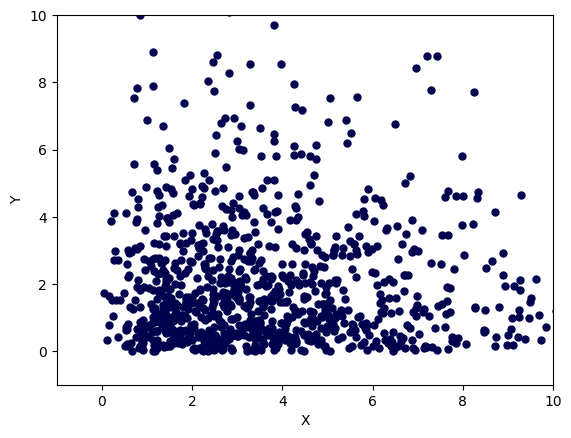

In [13]:
import matplotlib.pyplot as plt
col_red = '#c61826'
col_dark_red = '#590d08'
col_blue = '#01024d'
plt.figure()
plt.scatter(x[:, 0], x[:, 1],s=25, label='Original Data', alpha=1, color = col_blue)
plt.gca().set(xlim=(-1, 10), ylim=(-1, 10),
              xlabel='X', ylabel='Y')

[(-1.0, 10.0), (-1.0, 10.0), Text(0.5, 0, 'X'), Text(0, 0.5, 'Y')]

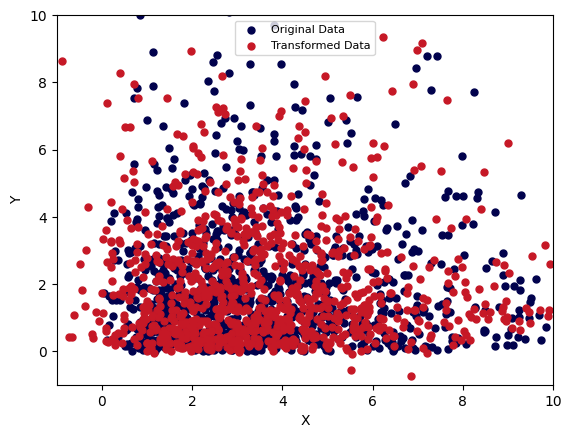

In [14]:
plt.scatter(x[:, 0], x[:, 1],s=25, label='Original Data', alpha=1, color = col_blue)
plt.scatter(result[:, 0], result[:, 1],s=25, label='Transformed Data', c = col_red)
plt.legend(fontsize=8)
plt.gca().set(xlim=(-1, 10), ylim=(-1, 10),
              xlabel='X', ylabel='Y')

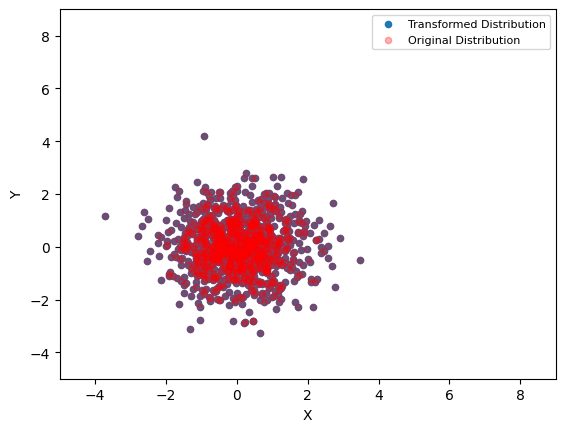

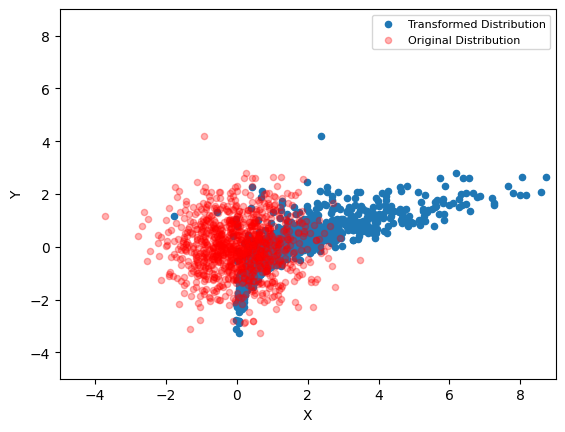

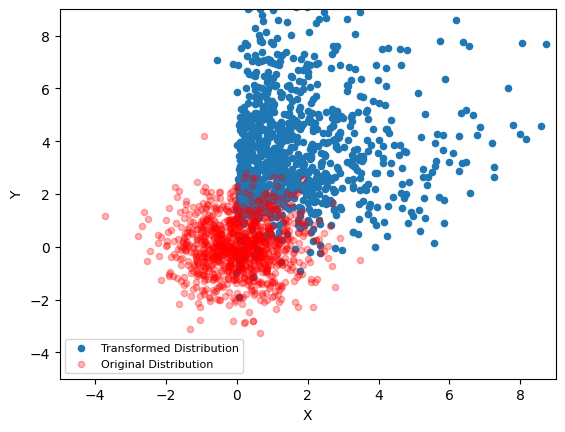

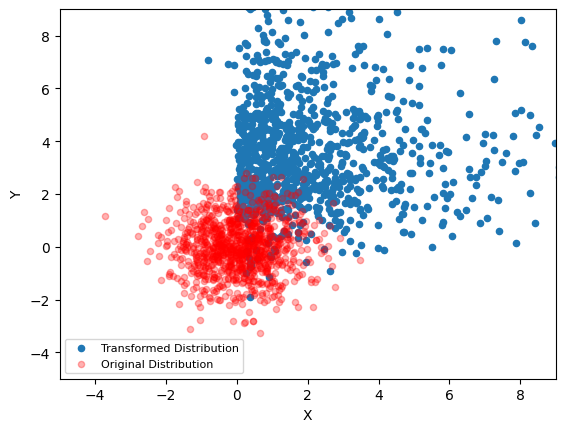

In [15]:
samples = th.tensor(np.random.normal([0, 0], 1, size = (1000, 2))).to(device)
switch = False
for i in range(num_blocks + 1):
    plt.figure()
    result = flow.backward_n_layers(samples.float(), i).detach().numpy()
    if switch:
        plt.scatter(result[:, 1], result[:, 0],s = 20, label='Transformed Distribution')
    else:
        plt.scatter(result[:, 0], result[:, 1],s = 20, label='Transformed Distribution')
    plt.scatter(samples[:, 0], samples[:, 1],s=20, label='Original Distribution', alpha=0.3, color = 'red')
    plt.legend(fontsize=8)
    # if i ==0:
    #     plt.title(f"Normal Distribution")
    # elif i == 1:
    #     plt.title(f"Distribution after {i} layer")
    # else:
    #     plt.title(f"Distribution after {i} layers")
    plt.gca().set(xlim=(-5, 9), ylim=(-5, 9),
              xlabel='X', ylabel='Y')
    switch = not switch
    plt.show()

In [16]:
def MMD(x, y):
        gamma = 2
        xx, yy, zz = th.mm(x, x.t()), th.mm(y, y.t()), th.mm(x, y.t())
        rx = (xx.diag().unsqueeze(0).expand_as(xx))
        ry = (yy.diag().unsqueeze(0).expand_as(yy))

        dxx = rx.t() + rx - 2. * xx # Used for A in (1)
        dyy = ry.t() + ry - 2. * yy # Used for B in (1)
        rxx = rx[0].repeat(y.shape[0], 1)
        ryy = ry[0].repeat(x.shape[0], 1) 
        dxy = rxx.t() + ryy - 2. * zz # Used for C in (1)

        XX, YY, XY = (th.zeros(xx.shape).to(device),
                      th.zeros(yy.shape).to(device),
                      th.zeros(zz.shape).to(device))
        XX += 1/(1 + dxx/gamma**2)
        YY += 1/(1 + dyy/gamma**2)
        XY += 1/(1 + dxy/gamma**2)
        return XX.mean() + YY.mean() - 2*XY.mean()

In [17]:
MMD(x, th.tensor(result))

tensor(0.0017)

In [18]:
MMD(x, th.tensor(samples).float())

/var/folders/mh/vvdpg_yd09bctt7g04w8hh800000gn/T/ipykernel_27723/718407094.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MMD(x, th.tensor(samples).float())


tensor(0.4670)

In [19]:
MMD(samples, samples)

tensor(0.)